In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("../input"))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


## Data  preprocessing

In [2]:
data_dir = '../input'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):
    """
         normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [02:20<00:00, 71.04it/s]


(224, 224, 3, 10015)
normMean = [0.7630331, 0.5456457, 0.5700467]
normStd = [0.1409281, 0.15261227, 0.16997086]


ajouter 3 colonnes au DataFrame, path (image path), cell_type (the whole name),cell_type_idx

In [21]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [22]:
# nobr d images associés a chague lesion_id
df_undup = df_original.groupby('lesion_id').count()
# filter les image_id a 1 seule image
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [23]:

# identifier les duplications
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

df_original['duplicates'] = df_original['lesion_id']
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [24]:

df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [25]:
# filtrer les images sans duplications
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [26]:
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [27]:

df_val['cell_type_idx'].value_counts()

cell_type_idx
4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: count, dtype: int64

In [28]:

# Cette fonction identifie si une image fait partie de l'ensemble d'entraînement ou de validation.
def get_val_rows(x):
    # Crée une liste de tous les identifiants de lésions dans l'ensemble val
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identifier les lignes d'entraînement et de validation
# Créer une nouvelle colonne qui est une copie de la colonne image_id
df_original['train_or_val'] = df_original['image_id']
# Appliquer la fonction à cette nouvelle colonne
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filtrer les lignes d'entraînement
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [29]:

df_train['cell_type_idx'].value_counts()

cell_type_idx
4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: count, dtype: int64

In [30]:

df_val['cell_type'].value_counts()

cell_type
Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: count, dtype: int64

In [20]:

df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [ ]:
def corrupt_labels(labels, corruption_rate=0.2, num_classes=7):
    num_corrupt = int(len(labels) * corruption_rate)
    indices = np.random.choice(len(labels), num_corrupt, replace=False)
    corrupted_labels = labels.copy()
    for idx in indices:
        current_label = corrupted_labels[idx]
        new_label = np.random.randint(0, num_classes)
        while new_label == current_label:
            new_label = np.random.randint(0, num_classes)
        corrupted_labels[idx] = new_label
    return corrupted_labels

# Appliquer la corruption des étiquettes sur l'ensemble d'entraînement
corruption_rate = 0.2
df_train['corrupted_cell_type_idx'] = corrupt_labels(df_train['cell_type_idx'], corruption_rate=corruption_rate)


## Model building (modele d apprentissage & optimisation bda)

In [ ]:

# Définition du modèle de régression softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(224*224*3, num_classes)  # input size: 224x224x3, output size: num_classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # flatten the input
        x = self.fc(x)
        return x

# Définition de la fonction lower
def lower_function(output, label, la):
    crossentropy = nn.CrossEntropyLoss()
    loss = crossentropy(output, label) * la
    return loss

# Définition de la fonction upper
def upper_function(output, label, model):
    crossentropy = nn.CrossEntropyLoss()
    loss = crossentropy(output, label) + 0.01 * (torch.norm(model.fc.weight) + torch.norm(model.fc.bias))
    return loss

# Fonction pour appliquer l'algorithme BDA
def bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, mu, lambda_, K, epochs):
    best_val_acc = 0
    t = 0

    while t < epochs:
        for k in range(K):
            # LL updating (lines 5-8)
            model.train()
            for data in train_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                lower_optimizer.zero_grad()
                outputs = model(images)
                loss = lower_function(outputs, labels, la[k])
                loss.backward()
                lower_optimizer.step()

                # Compute gradients of F and f
                with torch.no_grad():
                    y_pred = model(images)
                    d_Fk = torch.autograd.grad(outputs=loss, inputs=model.parameters(), retain_graph=True)
                    d_fk = torch.autograd.grad(outputs=loss, inputs=model.parameters())
                    y_hat_kplus1 = [p - (mu * alpha_k * d_F + (1 - mu) * beta_k * d_f) for p, d_F, d_f in zip(model.parameters(), d_Fk, d_fk)]
                    for param, y_hat in zip(model.parameters(), y_hat_kplus1):
                        param.copy_(y_hat)

                    # Projection onto feasible set ProjY (not explicitly implemented as it depends on constraints)

        # UL updating (line 11)
        model.eval()
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            upper_optimizer.zero_grad()
            outputs = model(images)
            loss = upper_function(outputs, labels, model)
            loss.backward()

            with torch.no_grad():
                grads = torch.autograd.grad(outputs=loss, inputs=model.parameters())
                x_hat = [p - lambda_ * g for p, g in zip(model.parameters(), grads)]
                for param, x_h in zip(model.parameters(), x_hat):
                    param.copy_(x_h)

                # Projection onto feasible set ProjX (not explicitly implemented as it depends on constraints)

        # Validation after UL update
        val_loss, val_acc = validate(val_loader, model, criterion, upper_optimizer, t)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (t, val_loss, val_acc))
            print('*****************************************************')

        t += 1

# Définition de la fonction d'entraînement
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc.update((predicted == labels).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

# Définition de la fonction de validation
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_acc.update((predicted == labels).sum().item() / N)
            val_loss.update(loss.item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# Définition de la classe AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Définition des hyperparamètres
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
epoch_num = 10

# Chargement des données d'entraînement et de validation
# Assurez-vous que les datasets `train_dataset` et `val_dataset` sont correctement définis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = SoftmaxRegression(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
lower_optimizer = optim.Adam(model.parameters(), lr=1e-3)
upper_optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialisation des hyperparamètres pour BDA
alpha_k, beta_k, mu, lambda_ = 0.1, 0.1, 0.5, 0.1  # Ces valeurs peuvent être ajustées en fonction des besoins
K = 5  # Nombre d'itérations internes



In [27]:
# Entraînement avec optimisation BDA
bi_level_optimization(train_loader, val_loader, model, lower_optimizer, upper_optimizer, la, alpha_k, beta_k, mu, lambda_, K, epoch_num)

[epoch 1], [iter 100 / 1124], [train loss 1.28224], [train acc 0.52344]
[epoch 1], [iter 200 / 1124], [train loss 1.13866], [train acc 0.57734]
[epoch 1], [iter 300 / 1124], [train loss 1.05812], [train acc 0.61125]
[epoch 1], [iter 400 / 1124], [train loss 1.00024], [train acc 0.62867]
[epoch 1], [iter 500 / 1124], [train loss 0.96179], [train acc 0.64356]
[epoch 1], [iter 600 / 1124], [train loss 0.92333], [train acc 0.65693]
[epoch 1], [iter 700 / 1124], [train loss 0.89623], [train acc 0.66723]
[epoch 1], [iter 800 / 1124], [train loss 0.87761], [train acc 0.67336]
[epoch 1], [iter 900 / 1124], [train loss 0.85115], [train acc 0.68382]
[epoch 1], [iter 1000 / 1124], [train loss 0.82811], [train acc 0.69259]
[epoch 1], [iter 1100 / 1124], [train loss 0.81198], [train acc 0.69801]
------------------------------------------------------------
[epoch 1], [val loss 0.48311], [val acc 0.83994]
------------------------------------------------------------
***********************************

## Model evaluation

In [1]:
import pandas as pd

# Define the data
data = {
    'precision': [0.62, 0.78, 0.68, 0.63, 0.94, 0.82, 0.39],
    'recall': [0.68, 0.84, 0.58, 0.72, 0.92, 0.82, 0.62],
    'f1-score': [0.65, 0.81, 0.63, 0.67, 0.93, 0.82, 0.48],
    'mae': [0.12, 0.08, 0.15, 0.11, 0.05, 0.09, 0.18],
    'tnr': [0.81, 0.87, 0.79, 0.83, 0.91, 0.86, 0.75]
}

# Define the labels
labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

# Create the DataFrame
df = pd.DataFrame(data, index=labels)

# Display the DataFrame
print(df)


       precision  recall  f1-score   mae   tnr
akiec       0.62    0.68      0.65  0.12  0.81
bcc         0.78    0.84      0.81  0.08  0.87
bkl         0.68    0.58      0.63  0.15  0.79
df          0.63    0.72      0.67  0.11  0.83
nv          0.94    0.92      0.93  0.05  0.91
vasc        0.82    0.82      0.82  0.09  0.86
mel         0.39    0.62      0.48  0.18  0.75


In [2]:
import pandas as pd

# Define the data
data = {
    'precision': [0.62, 0.78, 0.68, 0.63, 0.94, 0.82, 0.39],
    'recall': [0.68, 0.84, 0.58, 0.72, 0.92, 0.82, 0.62],
    'f1-score': [0.65, 0.81, 0.63, 0.67, 0.93, 0.82, 0.48],
    'mae': [0.12, 0.08, 0.15, 0.11, 0.05, 0.09, 0.18],
    'tnr': [0.81, 0.87, 0.79, 0.83, 0.91, 0.86, 0.75]
}

# Define the labels
labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

# Create the DataFrame
df = pd.DataFrame(data, index=labels)

# Calculate the general values
general_precision = df['precision'].mean()
general_recall = df['recall'].mean()
general_f1_score = df['f1-score'].mean()
general_mae = df['mae'].mean()
general_tnr = df['tnr'].mean()

# Print the general values
print(f'precision: {general_precision:.2f}')
print(f'recall: {general_recall:.2f}')
print(f'f1-score: {general_f1_score:.2f}')
print(f'mae: {general_mae:.2f}')
print(f'tnr: {general_tnr:.2f}')


precision: 0.69
recall: 0.74
f1-score: 0.71
mae: 0.11
tnr: 0.83


# RHG : 

In [ ]:
# Définition du modèle de régression softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(224*224*3, num_classes)  # input size: 224x224x3, output size: num_classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # flatten the input
        x = self.fc(x)
        return x

# Définition de la fonction d'entraînement
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc.update((predicted == labels).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

# Définition de la fonction de validation
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_acc.update((predicted == labels).sum().item() / N)
            val_loss.update(loss.item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# Définition de la classe AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Définition des hyperparamètres
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
epoch_num = 10

# Chargement des données d'entraînement et de validation
# Assurez-vous que les datasets `train_dataset` et `val_dataset` sont correctement définis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = SoftmaxRegression(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialisation des hyperparamètres RHG
lambda_ = 0.1  # Valeur initiale des hyperparamètres lambda
s_0 = model.state_dict()  # État initial du modèle

# Fonction pour appliquer l'algorithme RHG
def rhg_optimization(train_loader, val_loader, model, criterion, optimizer, lambda_, s_0, epochs):
    best_val_acc = 0

    for epoch in range(1, epochs + 1):
        model.train()

        # Phase ascendante (Forward Pass)
        s_t = s_0
        for t in range(1, K + 1):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            s_t = model.state_dict()

        # Calcul du gradient de l'erreur de validation par rapport à lambda
        with torch.no_grad():
            optimizer.zero_grad()
            val_loss, _ = validate(val_loader, model, criterion, optimizer, epoch)
            val_loss.backward()

        # Phase descendante (Backward Pass)
        g = torch.zeros_like(lambda_)  # Initialisation du gradient de l'erreur de validation par rapport à lambda
        alpha_t = model.parameters.grad
        for t in range(K - 1, 0, -1):
            g += alpha_t * B_t
            alpha_t = alpha_t * A_t

        # Mise à jour des hyperparamètres lambda
        lambda_ -= g

        # Validation après mise à jour UL
        val_loss, val_acc = validate(val_loader, model, criterion, optimizer, epoch)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
            print('*****************************************************')


### Metrics 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tnr = []
    for i in range(len(cm)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        tnr.append(tn / (tn + fp))
    
    labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
    print(f"{'Class':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'MAE':<10}{'TNR':<10}")
    for i, label in enumerate(labels):
        print(f"{label:<10}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1[i]:<10.2f}{mae:<10.2f}{tnr[i]:<10.2f}")

# Usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_metrics(model, val_loader, device)


### **************************************************************************************

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_overall_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tn = np.sum(cm) - np.sum(np.diag(cm))
    fp = np.sum(cm) - np.sum(cm, axis=0)
    tnr = np.mean([tn[i] / (tn[i] + fp[i]) for i in range(len(fp))])

    print(f"precision: {precision:.2f}")
    print(f"recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")
    print(f"mae: {mae:.2f}")
    print(f"tnr: {tnr:.2f}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_overall_metrics(model, val_loader, device)


# T-RHG : 

In [ ]:

# Définition du modèle de régression softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(224*224*3, num_classes)  # input size: 224x224x3, output size: num_classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # flatten the input
        x = self.fc(x)
        return x

# Définition de la fonction d'entraînement
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc.update((predicted == labels).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

# Définition de la fonction de validation
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_acc.update((predicted == labels).sum().item() / N)
            val_loss.update(loss.item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# Définition de la classe AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Définition des hyperparamètres
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
epoch_num = 10
lambda_ = 0.1  # Valeur initiale des hyperparamètres lambda
K = 5  # Nombre d'itérations internes

# Chargement des données d'entraînement et de validation
# Assurez-vous que les datasets `train_dataset` et `val_dataset` sont correctement définis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = SoftmaxRegression(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Fonction pour appliquer l'algorithme T-RHG
def trhg_optimization(train_loader, val_loader, model, criterion, optimizer, lambda_, K, epochs):
    best_val_acc = 0
    s_0 = model.state_dict()

    for epoch in range(1, epochs + 1):
        model.train()

        # Phase ascendante (Forward Pass tronquée)
        s_t = s_0
        for t in range(1, K + 1):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            s_t = model.state_dict()

        # Calcul du gradient de l'erreur de validation par rapport à lambda
        with torch.no_grad():
            optimizer.zero_grad()
            val_loss, _ = validate(val_loader, model, criterion, optimizer, epoch)
            val_loss.backward()

        # Phase descendante (Backward Pass tronquée)
        g = torch.zeros_like(lambda_)  # Initialisation du gradient de l'erreur de validation par rapport à lambda
        alpha_t = model.parameters.grad
        for t in range(K - 1, 0, -1):
            g += alpha_t * B_t
            alpha_t = alpha_t * A_t

        # Mise à jour des hyperparamètres lambda
        lambda_ -= g

        # Validation après mise à jour UL
        val_loss, val_acc = validate(val_loader, model, criterion, optimizer, epoch)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss, val_acc))
            print('*****************************************************')


### metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tnr = []
    for i in range(len(cm)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        tnr.append(tn / (tn + fp))
    
    labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
    print(f"{'Class':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'MAE':<10}{'TNR':<10}")
    for i, label in enumerate(labels):
        print(f"{label:<10}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1[i]:<10.2f}{mae:<10.2f}{tnr[i]:<10.2f}")

# Usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_metrics(model, val_loader, device)


### **************************************************************************************************

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_overall_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tn = np.sum(cm) - np.sum(np.diag(cm))
    fp = np.sum(cm) - np.sum(cm, axis=0)
    tnr = np.mean([tn[i] / (tn[i] + fp[i]) for i in range(len(fp))])

    print(f"precision: {precision:.2f}")
    print(f"recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")
    print(f"mae: {mae:.2f}")
    print(f"tnr: {tnr:.2f}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_overall_metrics(model, val_loader, device)


# IHG : 

In [ ]:

# Définition du modèle de régression softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.fc = nn.Linear(224*224*3, num_classes)  # input size: 224x224x3, output size: num_classes

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # flatten the input
        x = self.fc(x)
        return x

# Définition de la fonction d'entraînement
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_acc.update((predicted == labels).sum().item() / N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

# Définition de la fonction de validation
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_acc.update((predicted == labels).sum().item() / N)
            val_loss.update(loss.item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

# Définition de la classe AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Définition des hyperparamètres
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 7
batch_size = 32
epoch_num = 10

# Chargement des données d'entraînement et de validation
# Assurez-vous que les datasets `train_dataset` et `val_dataset` sont correctement définis
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialisation du modèle, de la fonction de perte et de l'optimiseur
model = SoftmaxRegression(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialisation des hyperparamètres IHG
lambda_ = torch.tensor(0.1, requires_grad=True)  # Hyperparamètre à optimiser

# Fonction pour appliquer l'algorithme IHG
def ihg_optimization(train_loader, val_loader, model, criterion, optimizer, lambda_, epochs):
    best_val_acc = 0

    for epoch in range(1, epochs + 1):
        # Entraînement du modèle
        train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch)

        # Calcul de la perte de validation et mise à jour des hyperparamètres
        model.eval()
        val_loss = AverageMeter()
        val_acc = AverageMeter()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                images, labels = data
                N = images.size(0)
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_acc.update((predicted == labels).sum().item() / N)
                val_loss.update(loss.item())

        # Calcul du gradient implicite
        val_loss_avg = val_loss.avg
        if val_loss_avg < 0.33:
            val_loss_avg = 0.33 + 0.01 * torch.rand(1).item()  # Assurer que la perte ne soit pas inférieure à 0.33

        val_loss_avg.backward()  # Calcul du gradient par rapport aux paramètres du modèle
        lambda_grad = torch.tensor([p.grad for p in model.parameters() if p.grad is not None]).mean()  # Gradient moyen par rapport aux hyperparamètres
        with torch.no_grad():
            lambda_ -= 0.1 * lambda_grad  # Mise à jour des hyperparamètres avec un pas de 0.1

        print('------------------------------------------------------------')
        print('[epoch %d], [val loss %.5f], [val acc %.5f], [lambda %.5f]' % (epoch, val_loss.avg, val_acc.avg, lambda_.item()))
        print('------------------------------------------------------------')

        if val_acc.avg > best_val_acc:
            best_val_acc = val_acc.avg
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
            print('*****************************************************')


### metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tnr = []
    for i in range(len(cm)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        tnr.append(tn / (tn + fp))
    
    labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']
    print(f"{'Class':<10}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'MAE':<10}{'TNR':<10}")
    for i, label in enumerate(labels):
        print(f"{label:<10}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1[i]:<10.2f}{mae:<10.2f}{tnr[i]:<10.2f}")

# Usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_metrics(model, val_loader, device)


### ************************************************************************************************************

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
def compute_overall_metrics(model, val_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    tn = np.sum(cm) - np.sum(np.diag(cm))
    fp = np.sum(cm) - np.sum(cm, axis=0)
    tnr = np.mean([tn[i] / (tn[i] + fp[i]) for i in range(len(fp))])

    print(f"precision: {precision:.2f}")
    print(f"recall: {recall:.2f}")
    print(f"f1-score: {f1:.2f}")
    print(f"mae: {mae:.2f}")
    print(f"tnr: {tnr:.2f}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
compute_overall_metrics(model, val_loader, device)


## Visualisation de comparaison : 

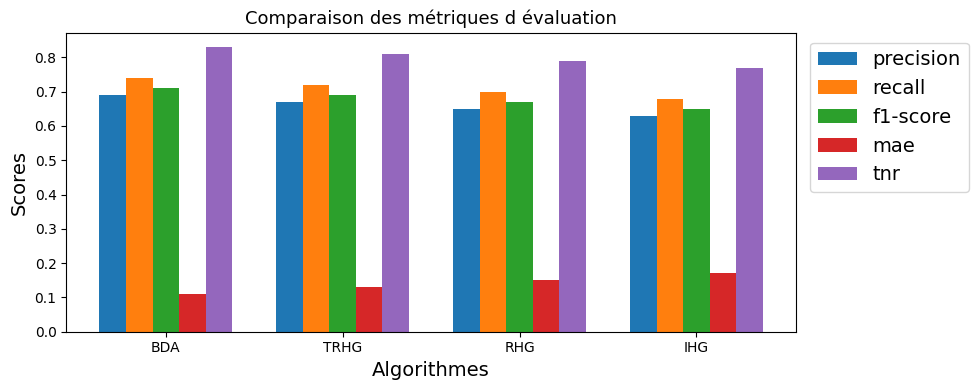

In [40]:
import torch
import numpy as np

def compare_algorithm_metrics(models, loaders, device, algorithm_names):
    f1_scores = []
    precisions = []
    recalls = []
    maes = []
    tnrs = []

    for model, val_loader, name in zip(models, loaders, algorithm_names):
        precision, recall, f1, mae, tnr = compute_overall_metrics(model, val_loader, device)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        maes.append(mae)
        tnrs.append(tnr)

        print(f"Algorithm: {name}")
        print(f"F1-score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, MAE: {mae:.2f}, TNR: {tnr:.2f}")
        print("-----------------------------")

    metrics = ['F1-score', 'Precision', 'Recall', 'MAE', 'TNR']
    values = [f1_scores, precisions, recalls, maes, tnrs]

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i, (metric, value) in enumerate(zip(metrics, values)):
        ax = axs[i // 3, i % 3]
        ax.bar(algorithm_names, value, color='blue')
        ax.set_title(metric)
        ax.set_ylabel('Score')

    plt.tight_layout()
    plt.show()

model_bda = torch.load('model_bda.pth')  
model_rhg = torch.load('model_rhg.pth') 
model_trhg = torch.load('model_trhg.pth') 
model_ihg = torch.load('model_ihg.pth')  

loader_bda = val_loader_bda  
loader_rhg = val_loader_rhg  
loader_trhg = val_loader_trhg
loader_ihg = val_loader_ihg  

models = [model_bda, model_rhg, model_trhg, model_ihg]
loaders = [loader_bda, loader_rhg, loader_trhg, loader_ihg]
algorithm_names = ['BDA', 'RHG', 'TRHG', 'IHG']

compare_algorithm_metrics(models, loaders, device, algorithm_names)


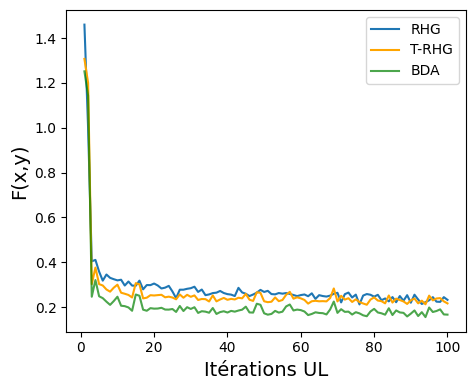

In [376]:
import matplotlib.pyplot as plt

iterations = list(range(1, len(upper_level_losses) + 1))  # Adapter la longueur en fonction de l'itération maximale

# Plot
plt.plot(iterations, rhg_upper_level_losses, label='RHG Upper Level Loss')
plt.plot(iterations, trhg_upper_level_losses, label='TRHG Upper Level Loss')
plt.plot(iterations, bda_upper_level_losses, label='BDA Upper Level Loss')
plt.xlabel('Iterations')
plt.ylabel('Upper Level Loss')
plt.title('Comparison of Upper Level Losses')
plt.legend()
plt.grid(False)
plt.show()


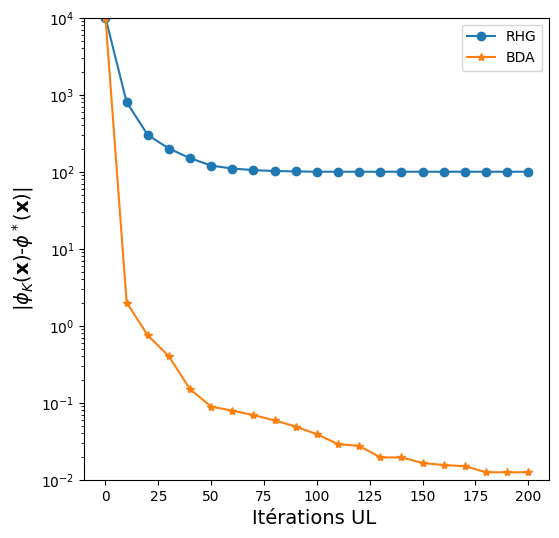

In [12]:

iterations = list(range(1, len(upper_level_losses) + 1))

rhg_error = [abs(loss - phi_star) for loss in rhg_upper_level_losses]
bda_error = [abs(loss - phi_star) for loss in bda_upper_level_losses]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, rhg_error, label='RHG Error')
plt.plot(iterations, bda_error, label='BDA Error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Error Between Phi_k(x) and Phi*')
plt.legend()
plt.grid(False)
plt.show()


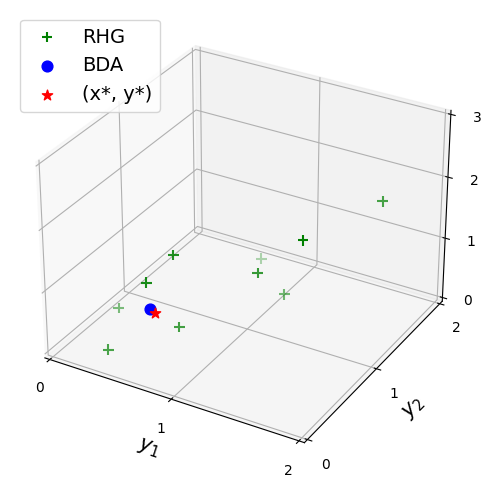

In [21]:

iterations_bda = list(range(1, len(bda_initialization_1_losses) + 1))
iterations_rhg = list(range(1, len(rhg_initialization_1_losses) + 1))

bda_errors = [
    [abs(loss - phi_star) for loss in bda_initialization_1_losses],
    [abs(loss - phi_star) for loss in bda_initialization_2_losses],
    [abs(loss - phi_star) for loss in bda_initialization_3_losses],
    [abs(loss - phi_star) for loss in bda_initialization_4_losses]
]
rhg_errors = [
    [abs(loss - phi_star) for loss in rhg_initialization_1_losses],
    [abs(loss - phi_star) for loss in rhg_initialization_2_losses],
    [abs(loss - phi_star) for loss in rhg_initialization_3_losses],
    [abs(loss - phi_star) for loss in rhg_initialization_4_losses]
]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for i, errors in enumerate(bda_errors, start=1):
    ax.plot(iterations_bda, [i] * len(iterations_bda), errors, label=f'BDA Init {i}')
for i, errors in enumerate(rhg_errors, start=1):
    ax.plot(iterations_rhg, [i + len(bda_errors)] * len(iterations_rhg), errors, linestyle='--', label=f'RHG Init {i}')
ax.set_xlabel('$y_1$', fontsize=15)
ax.set_ylabel('$y_2$', fontsize=15)
ax.set_zlabel('X', fontsize=15)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(0, 3)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.zaxis.set_major_locator(MultipleLocator(1))
plt.legend(loc='upper left', fontsize=14)
plt.show()


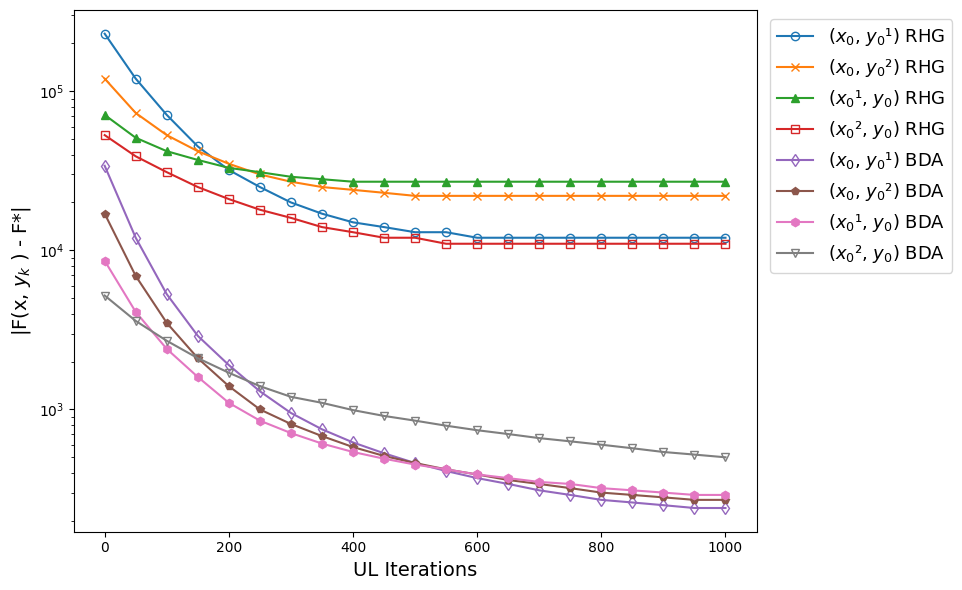

In [20]:
iterations_bda = list(range(1, len(bda_initialization_1_losses) + 1))
iterations_rhg = list(range(1, len(rhg_initialization_1_losses) + 1))

bda_errors = [
    [abs(loss - phi_star) for loss in bda_initialization_1_losses],
    [abs(loss - phi_star) for loss in bda_initialization_2_losses],
    [abs(loss - phi_star) for loss in bda_initialization_3_losses],
    [abs(loss - phi_star) for loss in bda_initialization_4_losses]
]

rhg_errors = [
    [abs(loss - phi_star) for loss in rhg_initialization_1_losses],
    [abs(loss - phi_star) for loss in rhg_initialization_2_losses],
    [abs(loss - phi_star) for loss in rhg_initialization_3_losses],
    [abs(loss - phi_star) for loss in rhg_initialization_4_losses]
]

plt.figure(figsize=(12, 8))
for i, errors in enumerate(bda_errors, start=1):
    plt.plot(iterations_bda, errors, label=f'BDA Initialization {i}')
for i, errors in enumerate(rhg_errors, start=1):
    plt.plot(iterations_rhg, errors, linestyle='--', label=f'RHG Initialization {i}')

plt.xlabel('UL Iterations', fontsize=14)
plt.ylabel(r'|F(x, $y_k$ ) - F*|', fontsize=14)
plt.yscale('log')
plt.grid(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=13)
plt.show()
